## Housing price prediction
The problem statement is to predict median house values in Californian districts, given a number of features from these districts.

The California Housing Prices dataset from the StatLib repository. This dataset is based on data from the 1990 California census. It is not exactly recent (a nice house in the Bay Area was still affordable at the time), but it has many qualities for learning, so we will pretend it is recent data.

Source: 
- https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

### Import necessary packages

In [1]:
import warnings
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

%matplotlib inline
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Data exploration

In [2]:
# Reading data from csv file
housing = pd.read_csv('housing.csv')
print("Size of the data: ", housing.shape)
housing.head()

Size of the data:  (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
# See the description of data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


Here we can see that **total_bedrooms** has 207 missing values which we will deal with later.

In [4]:
# Check the mean and standard deviation of the data
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Above data show that mean and standard deviation are different across all the features which indicates data are at different scale.

In [5]:
# Let's look at categorical feature "ocean_proximity"
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Plot histogram of each numerical features to visualize its distribution.

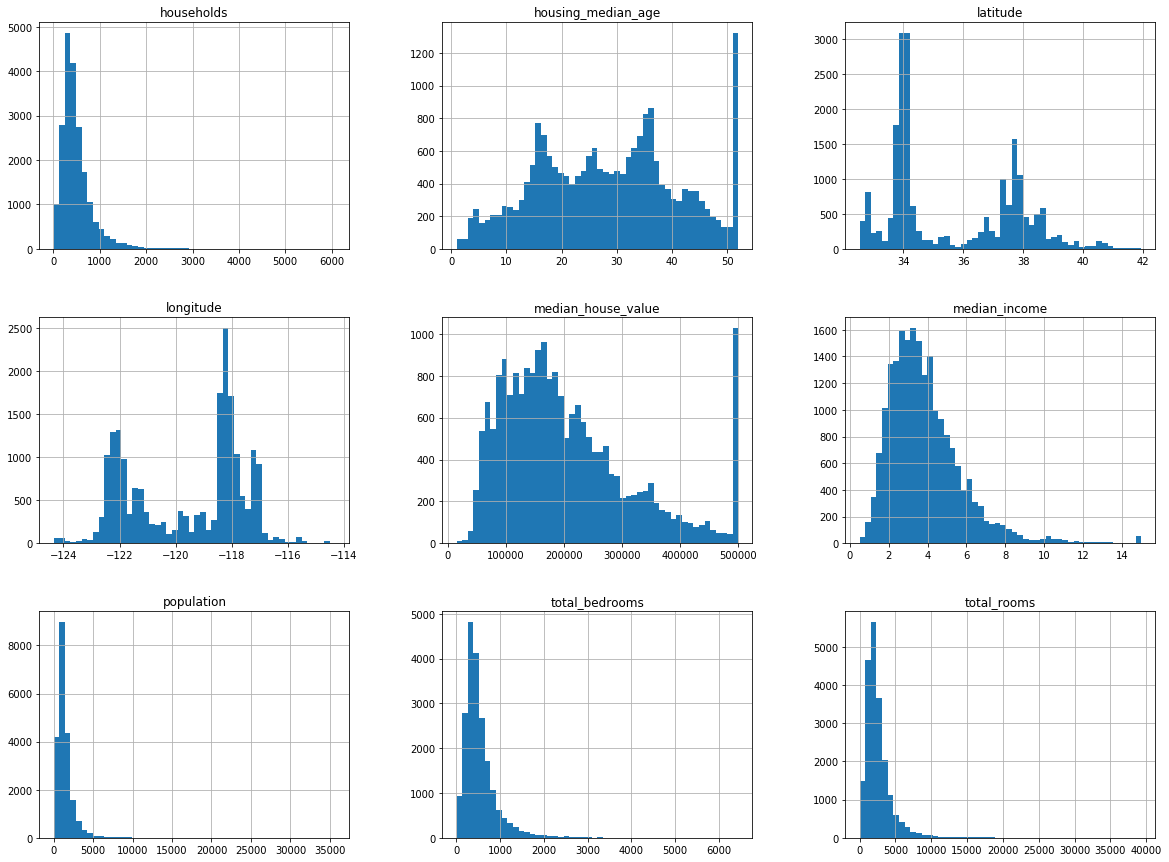

In [6]:
housing.hist(bins=50, figsize=(20, 15));

Here **meadian_income** is given in terms of $10,000.

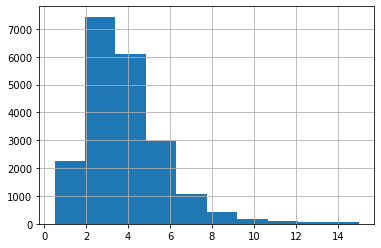

In [7]:
housing["median_income"].hist();

#### Visualize geographical data

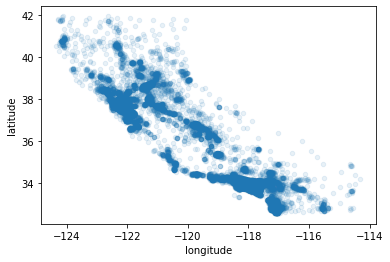

In [8]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1);

Above plot shows some of the high density area of california. 
Now look at the housing prices.

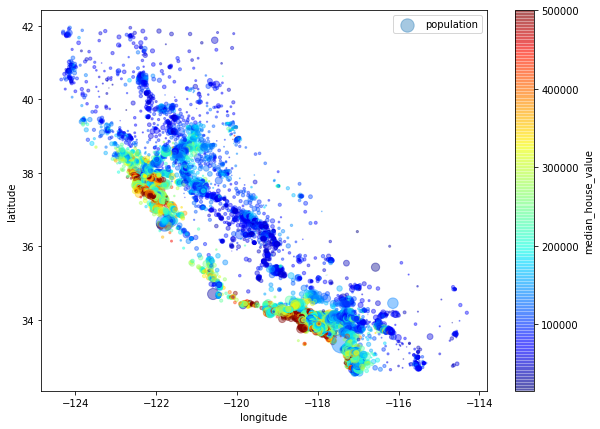

In [9]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend();

The radius of each circle represents the district's population (option s), and the color represents the price (option c). 
The red color represents higher prices while blue color is for lower prices. It is clear that prices are related to location.

Let's look at the correlation among features

In [10]:
corr_matrix = housing.corr()

In [11]:
# Look at how much each feature correlates with the median house value
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Plot correlation scatter matrix for few features

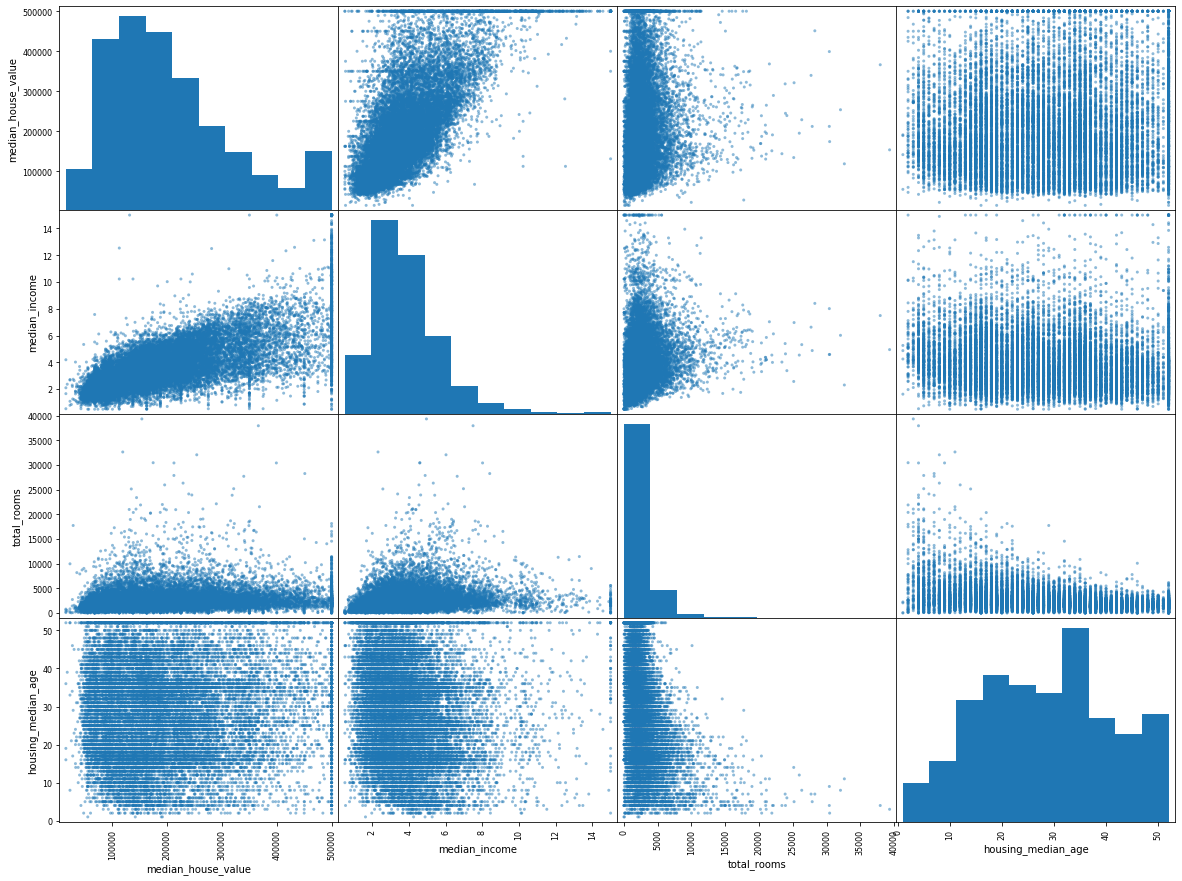

In [12]:
features = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[features], figsize=(20, 15));

The most promising feature to predict ***median_house_value*** is ***median_income***. Let's visualize it better,

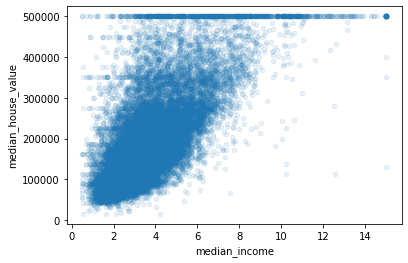

In [13]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1);

The correlation here is indeed very strong; you can clearly see the upward trend, and the points are not too dispersed.

Now, experiment with feature combination and see if that generate features with strong correlation with ***median_house_value***.

In [14]:
# Rooms per households
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
# Bedrooms per room
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
# Population per household
housing["population_per_household"]=housing["population"]/housing["households"]

In [15]:
# LEts check the correlation matrix
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

Here, we can see that ***bedrooms_per_room*** has strong negative correlation with ***median_house_value***.

In [16]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20640 non-null  float64
 1   latitude                  20640 non-null  float64
 2   housing_median_age        20640 non-null  float64
 3   total_rooms               20640 non-null  float64
 4   total_bedrooms            20433 non-null  float64
 5   population                20640 non-null  float64
 6   households                20640 non-null  float64
 7   median_income             20640 non-null  float64
 8   median_house_value        20640 non-null  float64
 9   ocean_proximity           20640 non-null  object 
 10  rooms_per_household       20640 non-null  float64
 11  bedrooms_per_room         20433 non-null  float64
 12  population_per_household  20640 non-null  float64
dtypes: float64(12), object(1)
memory usage: 2.0+ MB


#### Data preparation

In [17]:
# Seperate feeature columns and target variable
X_data = housing.drop('median_house_value', axis=1)
y_data = housing['median_house_value'].copy()

As we know that ***total_bedrooms*** has missing values. We need to fill those missing values by using imputing strategy.

In [18]:
imputer = SimpleImputer(strategy="median")

Since the median can only be computed on numerical features, we need to seperate numerical and categorical features.

In [19]:
X_data_numerical = X_data.drop('ocean_proximity', axis=1)
X_data_categorical = X_data['ocean_proximity'].copy()

In [20]:
# Fill missing values with median
imputer.fit(X_data_numerical)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [21]:
X_data_numerical = pd.DataFrame(imputer.transform(X_data_numerical), 
                                columns=X_data_numerical.columns,
                                index=X_data_numerical.index)

In [22]:
# Check again for missing values
X_data_numerical.isnull().sum().sum()

0

Encode categorical variable

In [23]:
one_hot_enc = OneHotEncoder(categories='auto')
data_encoded = one_hot_enc.fit_transform(X_data_categorical.values.reshape(-1,1))

In [24]:
one_hot_enc.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [25]:
X_data_categorical = pd.DataFrame(data_encoded.toarray(), 
                          columns=one_hot_enc.categories_,
                          index=X_data_categorical.index)

In [26]:
X_data_categorical.head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0


In [27]:
scaler = StandardScaler()
X_data_numerical = pd.DataFrame(scaler.fit_transform(X_data_numerical), 
                                columns=X_data_numerical.columns,
                                index=X_data_numerical.index)

In [28]:
X_data_numerical.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household
0,-1.327835,1.052548,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,0.628559,-1.149930,-0.049597
1,-1.322844,1.043185,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,0.327041,-0.990381,-0.092512
2,-1.332827,1.038503,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,1.155620,-1.445865,-0.025843
3,-1.337818,1.038503,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,0.156966,-0.493627,-0.050329
4,-1.337818,1.038503,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,0.344711,-0.707889,-0.085616


In [29]:
X_data = pd.concat([X_data_numerical, X_data_categorical], axis=1, sort=False)
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20640 non-null  float64
 1   latitude                  20640 non-null  float64
 2   housing_median_age        20640 non-null  float64
 3   total_rooms               20640 non-null  float64
 4   total_bedrooms            20640 non-null  float64
 5   population                20640 non-null  float64
 6   households                20640 non-null  float64
 7   median_income             20640 non-null  float64
 8   rooms_per_household       20640 non-null  float64
 9   bedrooms_per_room         20640 non-null  float64
 10  population_per_household  20640 non-null  float64
 11  (<1H OCEAN,)              20640 non-null  float64
 12  (INLAND,)                 20640 non-null  float64
 13  (ISLAND,)                 20640 non-null  float64
 14  (NEAR 

In [30]:
# Spliting dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

## Build and evaluate models

### Linear Regression

In [31]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
#To retrieve the intercept:
print(lr.intercept_)
#For retrieving the slope:
print(lr.coef_)

241729.27169525542
[-56718.03787585 -57136.01775183  13684.08264738   6257.52995912
   2179.78585958 -46231.51193099  42957.35233802  77591.5004857
   6806.73925819  15222.28664792   3049.08518585 -24071.441921
 -57886.02899512 129800.50300721 -28894.02551736 -18949.00657372]


In [33]:
y_pred = lr.predict(X_test)

In [34]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 48879.360730799664
Mean Squared Error: 4617527057.156778
Root Mean Squared Error: 67952.38816374874


It is clearly not a great score as a typical prediction error is large. This is an example of a model underfitting the training
data. When this happens it can mean that the features do not provide enough information to make good prediction or the model itself is not powerful enough!

Let's train more powerful model which is capable of finding complex nonlinear relationships in the data.

### Decision Tree Regressor

In [35]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [36]:
y_pred = dt.predict(X_test)

In [37]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 44577.39098837209
Mean Squared Error: 4853349377.75436
Root Mean Squared Error: 69665.98436650673


Here, Decision Tree seems to perform worse than the Linear Regression model!

### Random Forest Regressor

In [38]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [39]:
y_pred = rf.predict(X_test)

In [40]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 32137.757061531007
Mean Squared Error: 2416876083.1328025
Root Mean Squared Error: 49161.73393130884


Random Forest performes batter than Decision Trees and Linear Regression model.

#### Fine tune Random Forest Regressor

In [46]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_estimators': [3, 10, 30], 
        'max_features': [2, 4, 6, 8]
    }
  ]

rf = RandomForestRegressor(random_state=42)
# train across cross validation of 5 folds, that's a total of 12*5=60 rounds of training 
grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
  

In [47]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [48]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [49]:
cv_res = grid_search.cv_results_
for mean_score, params in zip(cv_res["mean_test_score"], cv_res["params"]):
    print(np.sqrt(-mean_score), params)

63706.831754394094 {'max_features': 2, 'n_estimators': 3}
55657.814891078786 {'max_features': 2, 'n_estimators': 10}
53055.91237099901 {'max_features': 2, 'n_estimators': 30}
60206.4708441335 {'max_features': 4, 'n_estimators': 3}
52585.233183435696 {'max_features': 4, 'n_estimators': 10}
50777.34507415388 {'max_features': 4, 'n_estimators': 30}
59027.990073158006 {'max_features': 6, 'n_estimators': 3}
52374.2075943758 {'max_features': 6, 'n_estimators': 10}
50124.35247933388 {'max_features': 6, 'n_estimators': 30}
58442.75571679764 {'max_features': 8, 'n_estimators': 3}
52217.38310303277 {'max_features': 8, 'n_estimators': 10}
50383.45502249349 {'max_features': 8, 'n_estimators': 30}


## Conclusion

We can observe that Random Forest Regressor outperformes Linear Regression and Decision Tree Regressor.